In [1]:
import numpy as np
import gensim

import glob
import os
import re

import tokenize_uk

path = './1551/'

files = glob.glob(path + '*.txt')

Read files and add categories and texts

In [2]:
data = dict()

for filename in os.listdir(path):
    category = dict()
    with open(path + filename, "r") as f:
        lines = f.readlines()
        
        for line in lines:
            if len(line) == 8 and line[0:7].isdigit():
                current_id = line[0:7]
                category[current_id] = ''
                continue
                
            if line == '\n':
                continue
                
            category[current_id] += ('' if category[current_id] == '' else ' ') + ' '.join(line.split('\n'))

    category_name = filename.split('.')[0]

    data[category_name] = category

    
print('Number of categories: ', len(data))


Number of categories:  188


In [3]:
def isfloat(x):
    try:
        a = float(x)
    except ValueError:
        return False
    else:
        return True

def flaten(l):
    return [item for sublist in l for item in sublist]

def get_tokens(request):
    tokens = flaten(flaten(tokenize_uk.tokenize_text(request.lower())))
    result = []
    for token in tokens:
        if len(token) < 2 or token.isdigit() or isfloat(token):
            continue
        result.append(token)
    return result

In [4]:
gmodel = gensim.models.KeyedVectors.load_word2vec_format("ubercorpus.lowercased.tokenized.word2vec.300d.bz2")

/home/serhii/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [5]:
size = 300
def get_embeddings(tokens):
    vec = np.zeros(size)
    sequence = []
    for token in tokens:
        if token in gmodel:
            embeding = gmodel[token]
            vec += embeding
            sequence.append(embeding)
            
    norm = np.linalg.norm(vec)
        
    if norm > 0:
        res = vec / norm
    else:
        res = vec
    
    return res, sequence


Build dataset

In [6]:
train_portion = 0.7

train_set = {
    'category': [],
    'id': [],
    'text': [],
    'tokens': [],
    'embeddings': [],
    'sequences': []
}
test_set = {
    'category': [],
    'id': [],
    'text': [],
    'tokens': [],
    'embeddings': [],
    'sequences': []
}

for category_name, category in data.items():
    
    num_requests = len(category)
    num_train = num_requests * train_portion
    
    counter = 0
    for r_id, request in category.items():
        
        tokens = get_tokens(request)
        embeddings, sequence = get_embeddings(tokens)
        
        if counter < num_train:
            train_set['category'].append(category_name)
            train_set['id'].append(r_id)
            train_set['text'].append(request)
            train_set['tokens'].append(tokens)
            train_set['embeddings'].append(embeddings)
            train_set['sequences'].append(sequence)
            
        else:
            test_set['category'].append(category_name)
            test_set['id'].append(r_id)
            test_set['text'].append(request)
            test_set['tokens'].append(tokens)
            test_set['embeddings'].append(embeddings)
            test_set['sequences'].append(sequence)
        
        counter+=1

## 1. KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score

In [8]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [24]:
knn.fit(train_set['embeddings'], train_set['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [10]:
prediction = knn.predict(test_set['embeddings'])

In [26]:
precision_score(test_set['category'], prediction, average='micro')

0.2856831282131173

Baseline precision is **28.6%**. I did not check the language and just skipped unknown words. Also I normilized sum of vectors to use just euclidean distance which is equivalent to cosine similarity if we use KNeighborsClassifier.

## 2.1. Logistic Regression

In [127]:
from sklearn.linear_model import LogisticRegression

In [128]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
clf.fit(train_set['embeddings'], train_set['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [129]:
lr_prediction = clf.predict(test_set['embeddings'])

In [130]:
precision_score(test_set['category'], lr_prediction, average='micro')

0.40660539024770215

Simple Logistic Regression shows much better result **40.7%**.

## 2.1. Random Forest

In [33]:
from numpy.core.umath_tests import inner1d
from sklearn.ensemble import RandomForestClassifier

In [49]:
clf_rf = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=0)
clf_rf.fit(train_set['embeddings'], train_set['category'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [50]:
rf_prediction = clf_rf.predict(test_set['embeddings'])

In [51]:
precision_score(test_set['category'], rf_prediction, average='micro')

0.2676429350366101

Random Forest shows worse result (**26.8%**).

## 2.2. SVM

In [52]:
from sklearn.svm import SVC

In [53]:
clf_svm = SVC(gamma='auto')
clf_svm.fit(train_set['embeddings'], train_set['category']) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [54]:
svm_prediction = clf_svm.predict(test_set['embeddings'])

In [55]:
precision_score(test_set['category'], svm_prediction, average='micro')

0.16220595108272318

SVM showed the worst result so far (**16.2%**).

### 3.1. LSTM

In [19]:
from keras import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

In [40]:
# The maximum number of words limit
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 200
# This is fixed.
EMBEDDING_DIM = 300

In [9]:
X = np.array(train_set['embeddings'] + test_set['embeddings'])
X.shape

(107256, 300)

In [13]:
Y = train_set['category'] + test_set['category']

encoder = LabelEncoder()
transfomed_label = encoder.fit_transform(Y)
Y = np.array(transfomed_label)
Y = to_categorical(Y)
print(Y.shape)

(107256, 188)


In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(75079, 300) (75079, 188)
(32177, 300) (32177, 188)


In [16]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(188, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [17]:
epochs = 5
batch_size = 64

history = model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
)

Instructions for updating:
Use tf.cast instead.
Train on 67571 samples, validate on 7508 samples
Epoch 1/5
67571/67571 [==============================] - 827s 12ms/step - loss: 4.4552 - acc: 0.1147 - val_loss: 4.4352 - val_acc: 0.1125
Epoch 2/5
67571/67571 [==============================] - 828s 12ms/step - loss: 4.4374 - acc: 0.1149 - val_loss: 4.4332 - val_acc: 0.1125
Epoch 3/5
67571/67571 [==============================] - 876s 13ms/step - loss: 4.4354 - acc: 0.1149 - val_loss: 4.4295 - val_acc: 0.1125
Epoch 4/5
67571/67571 [==============================] - 925s 14ms/step - loss: 4.4350 - acc: 0.1149 - val_loss: 4.4312 - val_acc: 0.1125
Epoch 5/5
67571/67571 [==============================] - 921s 14ms/step - loss: 4.4343 - acc: 0.1149 - val_loss: 4.4279 - val_acc: 0.1125


In [18]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

32177/32177 [==============================] - 103s 3ms/step
Test set
  Loss: 4.422
  Accuracy: 0.118


Base LSTM does not work well (**11.8%**). I guess it's because of using agregated embedding vector as sequence.

On the next step I am going to encode words as unique numbers and check the sequence of words.

## 3.1. LSTM 2.0

Prepare data to have a sequence of words encoded as unique number per word.

In [32]:
tokens_arr = train_set['tokens'] + test_set['tokens']

In [33]:
set_of_tokens = set()

for tokens in tokens_arr:
    for token in tokens:
        set_of_tokens.add(token)


In [34]:
tokens_dict = dict()
counter = 1
for token in set_of_tokens:
    tokens_dict[token] = counter
    counter+=1

In [36]:
data_set = {
    'tokens': tokens_arr,
    'num_sequenses': []
}

for tokens in tokens_arr:
    num_sequense = []
    for token in tokens:
        num_sequense.append(tokens_dict[token])
        
    data_set['num_sequenses'].append(num_sequense)

In [48]:
X2 = data_set['num_sequenses']
X2 = pad_sequences(X2, maxlen=MAX_SEQUENCE_LENGTH)
X2.shape

(107256, 200)

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X2, Y, test_size = 0.30, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(75079, 200) (75079, 188)
(32177, 200) (32177, 188)


In [55]:
MAX_NB_WORDS = len(set_of_tokens) + 1

model2 = Sequential()
model2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X2.shape[1]))
model2.add(SpatialDropout1D(0.2))
model2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(Y.shape[1], activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
epochs = 5
batch_size = 64

history = model2.fit(
    X_train,
    Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
)

Train on 67571 samples, validate on 7508 samples
Epoch 1/5
67571/67571 [==============================] - 1353s 20ms/step - loss: 3.6384 - acc: 0.2390 - val_loss: 2.8195 - val_acc: 0.3436
Epoch 2/5
67571/67571 [==============================] - 1261s 19ms/step - loss: 2.3783 - acc: 0.4195 - val_loss: 2.0419 - val_acc: 0.4859
Epoch 3/5
67571/67571 [==============================] - 1262s 19ms/step - loss: 1.6402 - acc: 0.5707 - val_loss: 1.6878 - val_acc: 0.5651
Epoch 4/5
67571/67571 [==============================] - 1265s 19ms/step - loss: 1.1456 - acc: 0.6893 - val_loss: 1.5818 - val_acc: 0.5924
Epoch 5/5
67571/67571 [==============================] - 1263s 19ms/step - loss: 0.7913 - acc: 0.7820 - val_loss: 1.5816 - val_acc: 0.6028


I took only 5 epochs because it takes to much time to train this model on the laptop. This model shows much better results than the previous one.

In [57]:
accr = model2.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

32177/32177 [==============================] - 71s 2ms/step
Test set
  Loss: 1.561
  Accuracy: 0.606


This LSTM model shows pretty high accuracy (**60.6%**) comparing to the previous models.

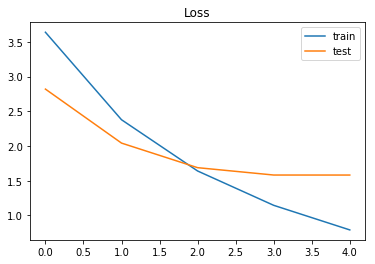

In [58]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

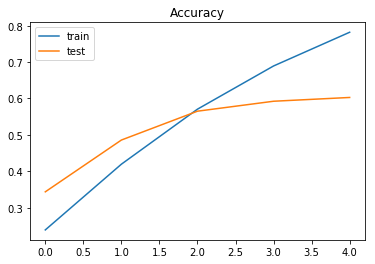

In [59]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

Perhaps the result would be better if it has more epochs for training but as we can see from the plots, test set accuracy does not increase enough after 5 epochs.

In [60]:
MAX_NB_WORDS = len(set_of_tokens) + 1

model3 = Sequential()
model3.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X2.shape[1]))
model3.add(SpatialDropout1D(0.2))
model3.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(Y.shape[1], activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
epochs = 15
batch_size = 64

history = model3.fit(
    X_train,
    Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
)

Train on 67571 samples, validate on 7508 samples
Epoch 1/15
67571/67571 [==============================] - 1204s 18ms/step - loss: 3.5722 - acc: 0.2505 - val_loss: 2.7726 - val_acc: 0.3558
Epoch 2/15
67571/67571 [==============================] - 1184s 18ms/step - loss: 2.3291 - acc: 0.4269 - val_loss: 2.0294 - val_acc: 0.4871
Epoch 3/15
67571/67571 [==============================] - 1185s 18ms/step - loss: 1.6078 - acc: 0.5771 - val_loss: 1.6714 - val_acc: 0.5659
Epoch 4/15
67571/67571 [==============================] - 1187s 18ms/step - loss: 1.1042 - acc: 0.6971 - val_loss: 1.5456 - val_acc: 0.6066
Epoch 5/15
67571/67571 [==============================] - 1186s 18ms/step - loss: 0.7268 - acc: 0.8009 - val_loss: 1.5533 - val_acc: 0.6137
Epoch 6/15
67571/67571 [==============================] - 1187s 18ms/step - loss: 0.4662 - acc: 0.8771 - val_loss: 1.6606 - val_acc: 0.6067
Epoch 7/15
67571/67571 [==============================] - 1188s 18ms/step - loss: 0.2950 - acc: 0.9269 - val_lo

In [62]:
accr = model3.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

32177/32177 [==============================] - 62s 2ms/step
Test set
  Loss: 1.732
  Accuracy: 0.604


Learning stopped after 7 epochs with almost the same result.